## Latent Dirichlet Allocation

In [1]:
from octis.models.LDA import LDA
from octis.dataset.dataset import Dataset
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence
from octis.optimization.optimizer import Optimizer
from skopt.space.space import Real, Integer
import numpy as np
import time
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
from wordcloud import WordCloud

In [2]:
dummy_run = False

if(dummy_run):
    num_iters = 5
    number_of_calls = 2
else:
    num_iters = 100
    number_of_calls = None # Depends on size of search space

In [3]:
# Load the dataset
dataset = Dataset()  
dataset.fetch_dataset("BBC_News")
#dataset.load_custom_dataset_from_folder("data/processed") # Our custom preprocessed dataset

Make sure that the dataset is in the following format:
corpus file: a .tsv file (tab-separated) that contains up to three columns, i.e. the document, the partitition, and the label associated to the document (optional).
vocabulary: a .txt file where each line represents a word of the vocabulary
The partition can be "train" for the training partition, "test" for testing partition, or "val" for the validation partition. An example of dataset can be found here: sample_dataset.



In [4]:
# Some data exploration
print(len(dataset._Dataset__corpus))
print(len(dataset._Dataset__vocabulary))
print(dataset._Dataset__corpus[1])

2225
2949
['plan', 'share', 'sale', 'owner', 'technology', 'dominate', 'index', 'plan', 'sell', 'share', 'public', 'list', 'market', 'operate', 'accord', 'document', 'file', 'stock', 'market', 'plan', 'raise', 'sale', 'observer', 'step', 'close', 'full', 'public', 'icon', 'technology', 'boom', 'recently', 'pour', 'cold', 'water', 'suggestion', 'company', 'sell', 'share', 'private', 'technically', 'public', 'stock', 'start', 'trade', 'list', 'equity', 'trade', 'money', 'sale', 'investor', 'buy', 'share', 'private', 'filing', 'document', 'share', 'technology', 'firm', 'company', 'high', 'growth', 'potential', 'symbol', 'internet', 'telecom', 'boom', 'bubble', 'burst', 'recovery', 'fortune', 'tech', 'giant', 'dot', 'revive', 'fortune']


## Metrics

In [5]:
td, ch = TopicDiversity(topk=10), Coherence(topk=10, measure = 'c_v') # Initialize metric

## Without optimization

In [6]:
# Create Model
model = LDA(num_topics=20)

In [7]:
coherence_list_no_opt, topic_diversity_list_no_opt, iters = [], [], num_iters

for i in tqdm(range(iters)):
  output = model.train_model(dataset)
  coherence_list_no_opt.append(ch_score := ch.score(output))
  topic_diversity_list_no_opt.append(td_score := td.score(output))

print("Mean coherence: ", np.mean(coherence_list_no_opt), "\nMean topic diversity: ", np.mean(topic_diversity_list_no_opt))

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [05:27<00:00,  3.27s/it]

Mean coherence:  0.40837649503127843 
Mean topic diversity:  0.33255


## With optimization

In [8]:
model = LDA()

In [11]:
# Optimization for hyperparameters based on coherence (to be substituted with a combination of ch e td ?)


# Define the search space. To see which hyperparameters to optimize, see the topic model's initialization signature
search_space = {"num_topics": Integer(low=5, high=50),
                "offset": Integer(low=1, high=100),
                "decay": Real(low=0.5, high=1.0)}

# Initialize an optimizer object and start the optimization.
optimizer=Optimizer()

if(number_of_calls == None):
    number_of_calls = len(search_space.keys())*15


print(number_of_calls)

45


In [12]:

start = time.time() # Just to see, to be removed.

# This uses the default optimization method (Bayesian optimization) and the default metric (coherence) to optimize the model, try also random search.

optResult=optimizer.optimize(model, dataset, ch, search_space, save_path="results/test_LDA", # path to store the results
                            number_of_call=number_of_calls, # number of optimization iterations: rule of thumb 15*num_hyperparameters
                            model_runs=5, # number of runs of the topic model: can be increased but takes more time
                            plot_best_seen=True, # plot the best seen value of the metric
                            extra_metrics = [td],
                            plot_model=True, # plot the topic model
                            early_step=10, # number of iterations after which the optimization stops if no improvement
                            surrogate_model='GP', # surrogate model for the optimization: gaussian process
                            random_state=123)

#save the results of th optimization in a csv file
optResult.save_to_csv("results.csv")

end = time.time()
duration = end - start

print('Optimizing model took: ' + str(round(duration)) + ' seconds.')

Current call:  0
Current call:  1
Current call:  2
Current call:  3
Current call:  4
Current call:  5
Current call:  6
Current call:  7
Current call:  8
Current call:  9
Current call:  10
Current call:  11
Current call:  12
Current call:  13
Current call:  14
Current call:  15
Current call:  16
Current call:  17
Current call:  18
Current call:  19
Current call:  20
Current call:  21
Current call:  22
Current call:  23
Current call:  24
Current call:  25
Current call:  26
Current call:  27
Current call:  28
Current call:  29
Current call:  30
Current call:  31
Current call:  32
Current call:  33
Current call:  34
Current call:  35
Current call:  36
Current call:  37
Current call:  38
Current call:  39
Current call:  40
Current call:  41
Current call:  42
Current call:  43
Current call:  44
Optimizing model took: 346 seconds.


In [13]:
results = json.load(open("results/test_LDA/result.json",'r'))
results.keys()

dict_keys(['dataset_name', 'dataset_path', 'is_cached', 'kernel', 'acq_func', 'surrogate_model', 'optimization_type', 'model_runs', 'save_models', 'save_step', 'save_name', 'save_path', 'early_stop', 'early_step', 'plot_model', 'plot_best_seen', 'plot_name', 'log_scale_plot', 'search_space', 'model_name', 'model_attributes', 'use_partitioning', 'metric_name', 'extra_metric_names', 'metric_attributes', 'extra_metric_attributes', 'current_call', 'number_of_call', 'random_state', 'x0', 'y0', 'n_random_starts', 'initial_point_generator', 'topk', 'time_eval', 'dict_model_runs', 'f_val', 'x_iters'])

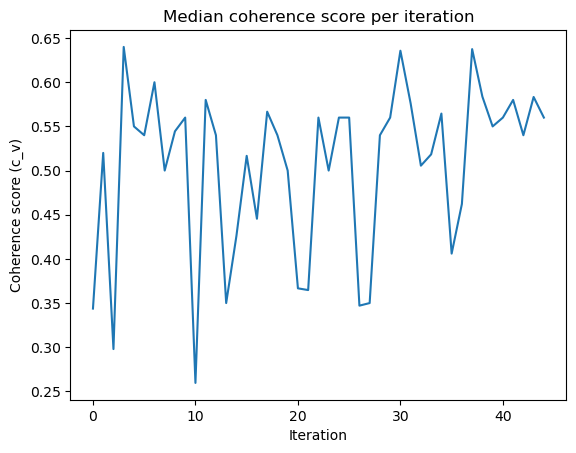

In [14]:
plt.xlabel('Iteration')
plt.ylabel('Coherence score (c_v)')
plt.title('Median coherence score per iteration')
plt.plot(results["f_val"])
plt.show()

In [48]:
max_index = results["f_val"].index(max(results["f_val"]))
print(results["f_val"][max_index])


0.64
{'0_TopicDiversity': {'topk': 10}}


In [16]:
print(results["x_iters"].keys())

num_topics = results["x_iters"]["num_topics"][max_index]
offset = results["x_iters"]["offset"][max_index]
decay = results["x_iters"]["decay"][max_index]

print("Optimal number of topics: ", num_topics)
print("Optimal offset: ", offset)
print("Optimal decay: ", decay)

dict_keys(['decay', 'num_topics', 'offset'])
Optimal number of topics:  5
Optimal offset:  95
Optimal decay:  0.9810390284380395


Now we're ready to train it. See that the output of a topic model comes as a dictionary composed of 4 elements:


*   *topics*: the list of word topics
*   *topic-word-matrix*: the distribution of the words of the vocabulary for each topic (dimensions: |num topics| x |vocabulary|)
*   *topic-document-matrix*: the distribution of the topics for each document of the training set (dimensions: |num topics| x |training documents|)
*   *test-document-topic-matrix*: the distribution of the topics for each document of the testing set (dimensions: |num topics| x |test documents|)



In [17]:
model = LDA(num_topics=num_topics, decay = decay, offset=offset)

In [18]:
# Train the model using default partitioning choice
output = model.train_model(dataset)

In [19]:
coherence_list, topic_diversity_list, iters = [], [], num_iters

for i in tqdm(range(iters)):
  output = model.train_model(dataset)
  coherence_list.append(ch_score := ch.score(output))
  topic_diversity_list.append(td_score := td.score(output))



print("Mean coherence: ", np.mean(coherence_list), "\nMean topic diversity: ", np.mean(topic_diversity_list))

100%|██████████| 100/100 [04:33<00:00,  2.74s/it]

Mean coherence:  0.4078194733879281 
Mean topic diversity:  0.5844


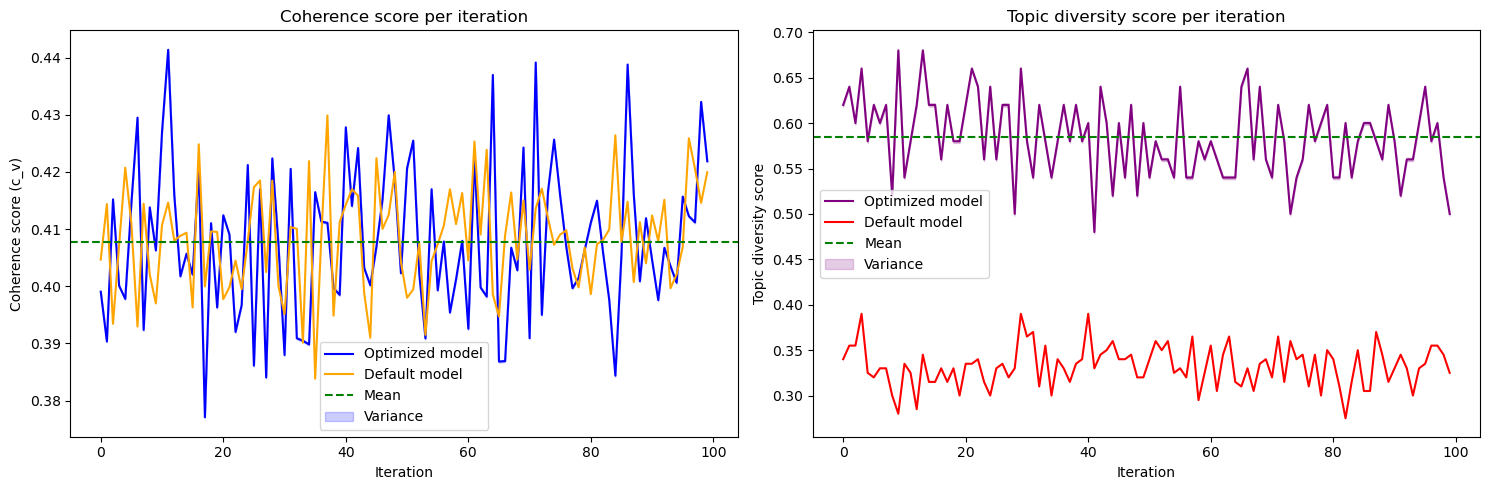

In [20]:

# Example data (replace with your actual data)
iterations = len(coherence_list)
mean_coherence = np.mean(coherence_list)
var_coherence = np.var(coherence_list)
mean_topic_diversity = np.mean(topic_diversity_list)
var_topic_diversity = np.var(topic_diversity_list)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Coherence score plot
axs[0].plot(coherence_list, label='Optimized model', color='blue')
axs[0].plot(coherence_list_no_opt, label='Default model', color='orange')
axs[0].axhline(y=mean_coherence, color='green', linestyle='--', label='Mean')
axs[0].fill_between(
    range(iterations), 
    coherence_list - var_coherence, 
    coherence_list + var_coherence, 
    color='blue', alpha=0.2, label='Variance'
)
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Coherence score (c_v)')
axs[0].set_title('Coherence score per iteration')
axs[0].legend()

# Topic diversity score plot
axs[1].plot(topic_diversity_list, label='Optimized model', color='purple')
axs[1].plot(topic_diversity_list_no_opt, label='Default model', color='red')
axs[1].axhline(y=mean_topic_diversity, color='green', linestyle='--', label='Mean')
axs[1].fill_between(
    range(iterations), 
    topic_diversity_list - var_topic_diversity, 
    topic_diversity_list + var_topic_diversity, 
    color='purple', alpha=0.2, label='Variance'
)
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Topic diversity score')
axs[1].set_title('Topic diversity score per iteration')
axs[1].legend()

plt.tight_layout()
plt.show()




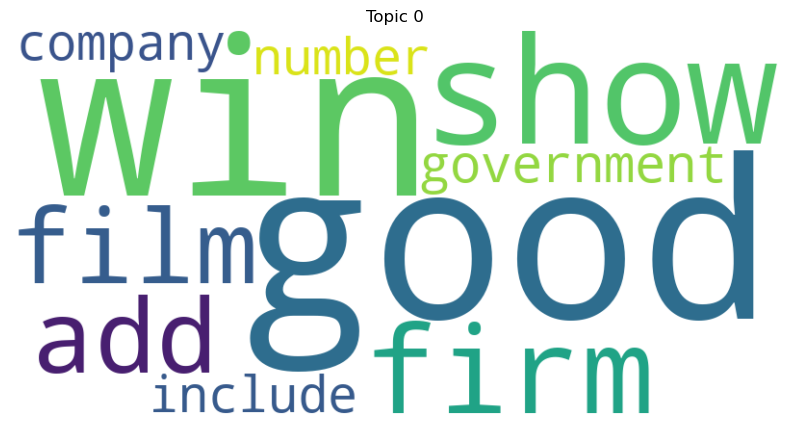

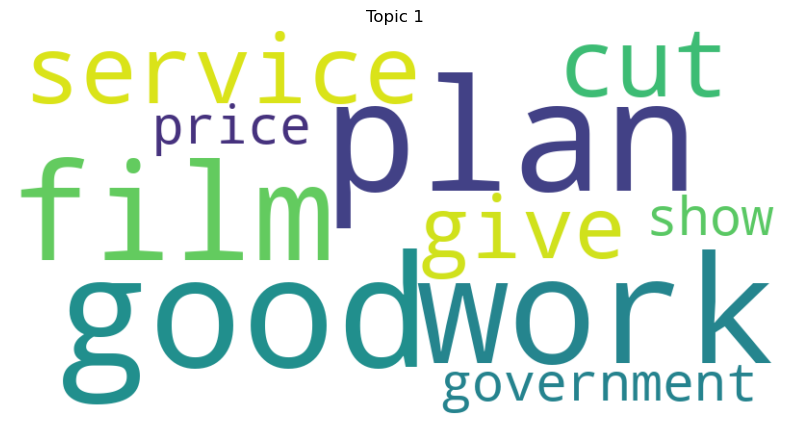

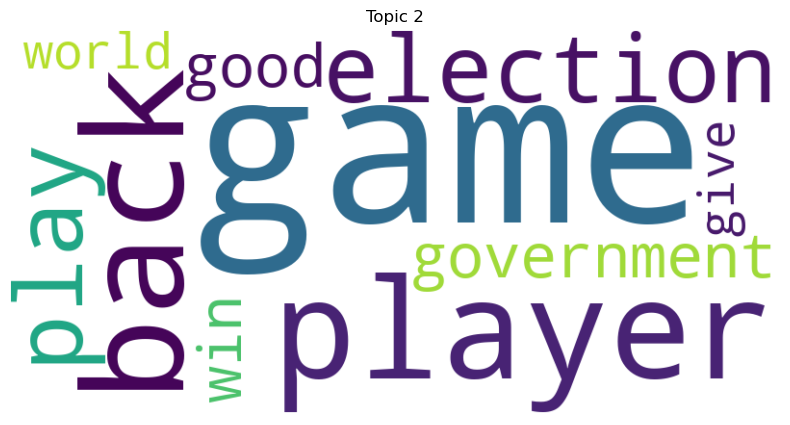

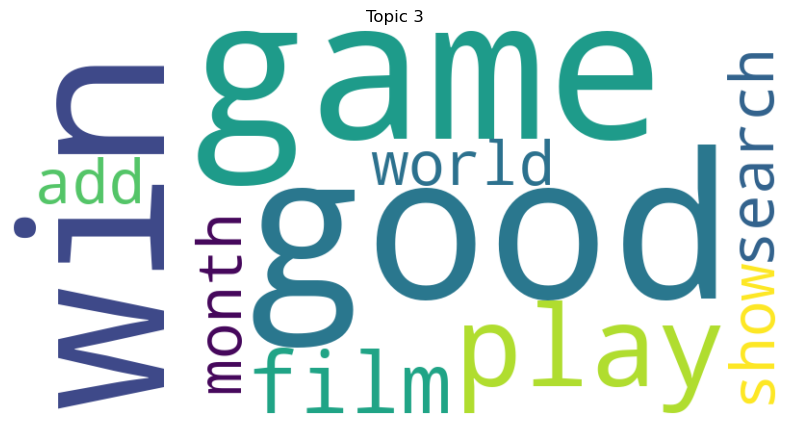

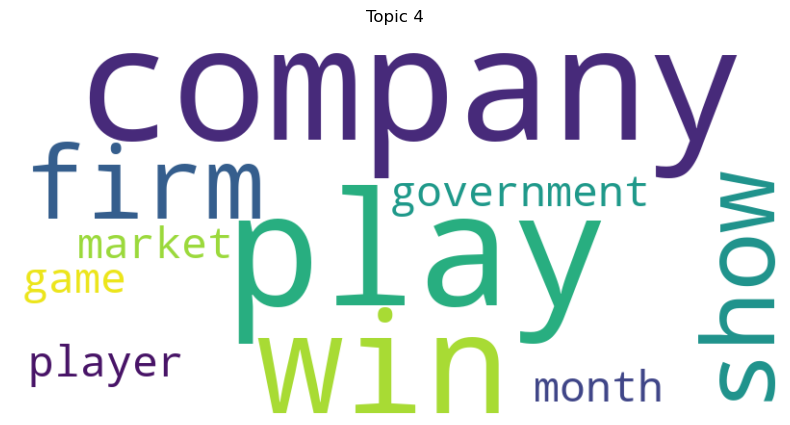

In [21]:
topics = output['topics']
for i, topic in enumerate(topics):
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(topic))
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f"Topic {i}")
  plt.show()


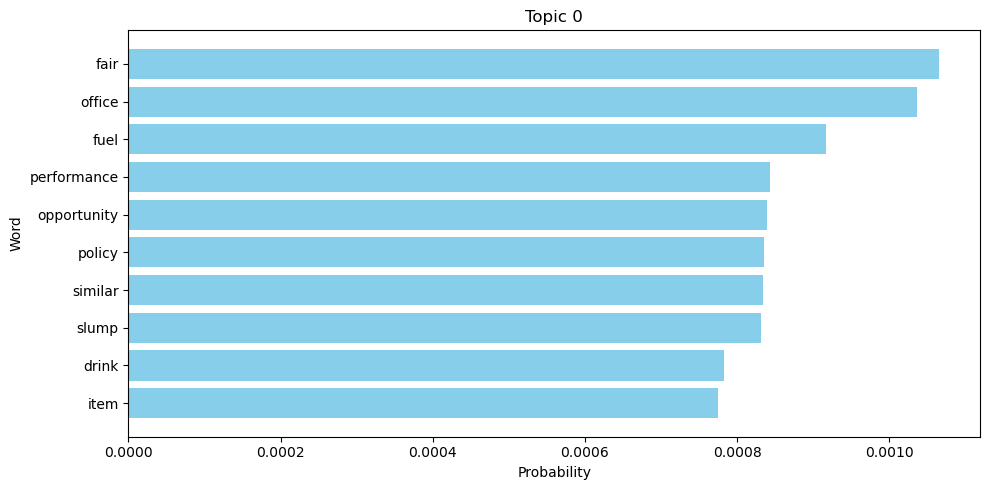

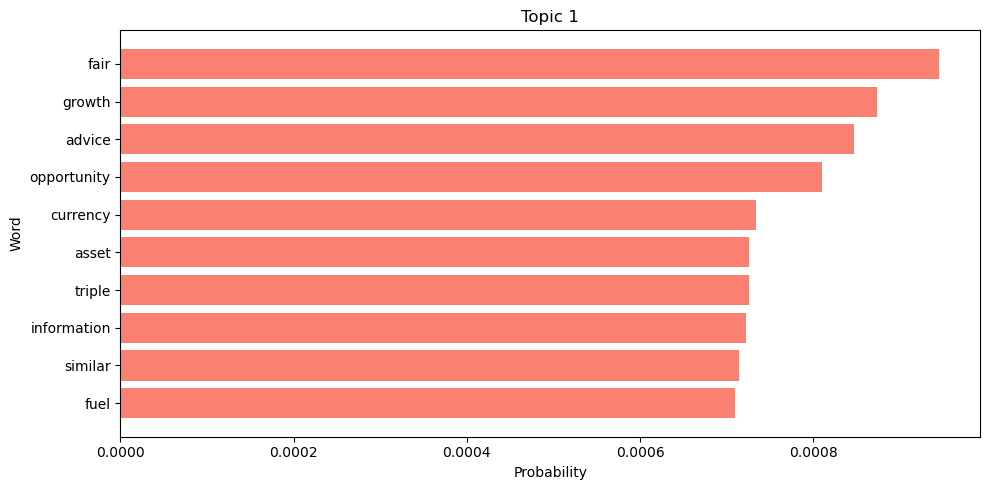

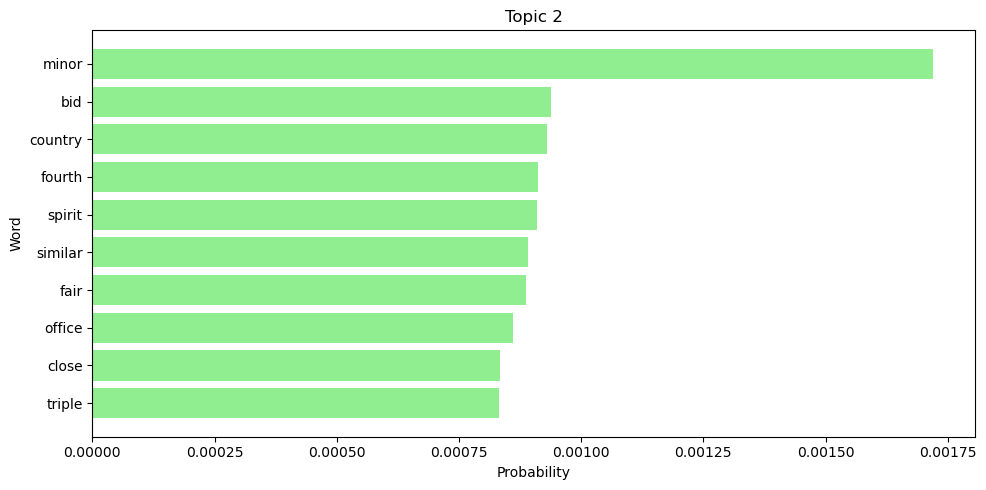

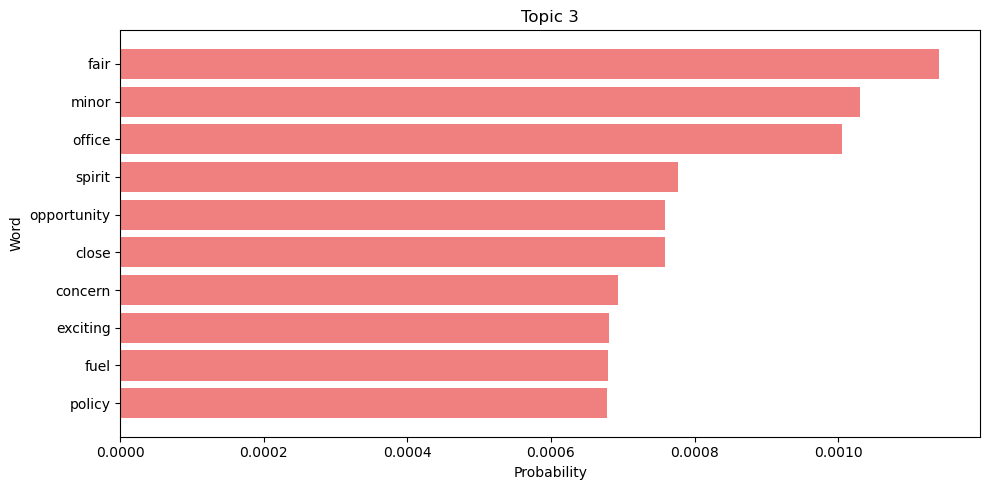

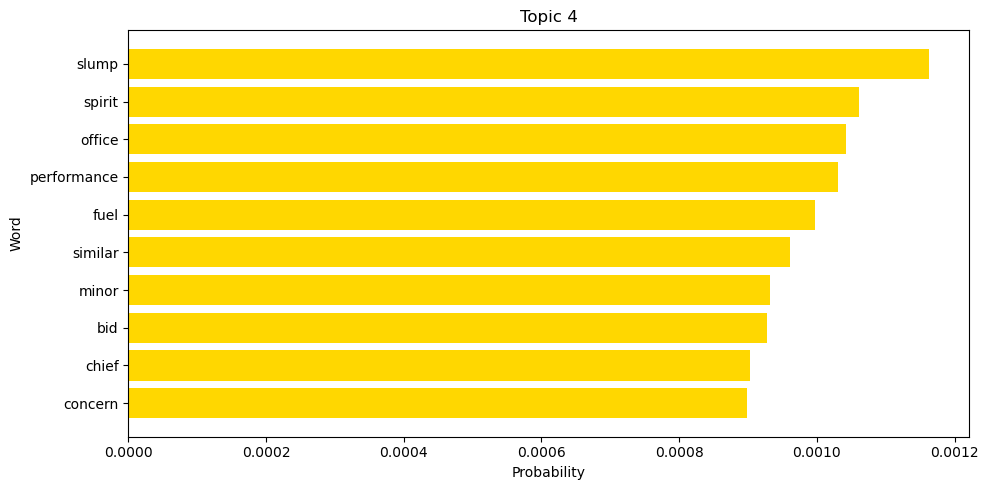

In [22]:
topic_word_matrix = output['topic-word-matrix']
words = dataset.get_vocabulary()  # List of all words in the vocabulary

# Number of words to display 
top_n_words = 10

colors = ['skyblue', 'salmon', 'lightgreen', 'lightcoral', 'gold', 'orchid', 'cyan', 'peachpuff', 'cornflowerblue', 'palegreen']

# Display the top n words for each topic in a bar plot
for i, topic in enumerate(topic_word_matrix):
    # Get the top N words and their probabilities
    top_n_words_indices = np.argsort(topic)[::-1][:top_n_words]
    top_n_words_values = [topic[i] for i in top_n_words_indices]
    top_n_words_words = [words[i] for i in top_n_words_indices]

    # Use a different color for each topic
    color = colors[i % len(colors)]  # Cycle through the list of colors

    # Create horizontal bar plot
    plt.figure(figsize=(10, 5))
    plt.barh(top_n_words_words, top_n_words_values, color=color)
    plt.xlabel("Probability")
    plt.ylabel("Word")
    plt.title(f"Topic {i}")
    
    # Invert y-axis for readability
    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()
